# Muliple Overfeed Underfeed Cycles
MII 13/05/2021

In [ ]:
pwd

In [2]:
import sys
sys.path.append('../')

In [3]:
# Do imports first
import Global as Glob
import Model as Mod
import numpy as np
import InputSimulation as InpSim
import ObservationSimulation as ObSim
import StateSimulation as StateSim
import UnscentedKalmanFilterSim as UKFSim

In [4]:
'''
# Establish Simulation and trnasformation matrices
'''
# 20 minutes underfeed, simulation at 5 sec intervals
dt = 5
nt = 240
(F, G, H, B) = Mod.StateEquations(dt)

In [5]:
# Define the UKF noise standard deviations
q1dstd = 0.0002    # alumina concentration variation
q1ustd = 0.0002    # undisolved alumina concentration variation
q2std = 0.0000001  # acd varation needs to be much lower
# array of state variation terms
qstd = np.array([[q1dstd], [q1ustd], [q2std]])
rstd = 0.001      # measurement variation (volts)
Istd = 200         # Line Current input variation (amps)

In [6]:
Shotstd = 0.1      # Shot mass standard deviation (kg)
ShotOffset = 0.0  # Discrepancy between nominal and actual shot mass (kg)

In [7]:
OFmass = 24        # 25 kg overfeed mass in excess of consumption
OFrate = 1.5       # Overfeed delivered at 1.5 times nominal rate

In [8]:
NomCycles = 5       # The number of nominal feed cycles to simulate
AdaptiveCycles = 5  # The number of OF-Nom-UF cycles to simulate

In [9]:
# start with initial concentrations at end of previous underfeed of:
# 2.8% dissolved
# 0.1% undissolved
# starting ACD of 29.2 mm
x0 = np.array([[2.8], [0.1], [2.9193]])
u0 = np.array([[126000], [0.0], [0.0]])

In [10]:
for i in range(AdaptiveCycles):

    # simulate inputs for Overfeed
    utOF, unomOF = InpSim.uOverFeeding(u0, (Glob.AlDump+ShotOffset), Shotstd, Istd, dt, OFmass, OFrate)

    # simulate inputs for Nominal Feed
    utNom, unomNom = InpSim.uNominalFeeding(u0, (Glob.AlDump+ShotOffset), Shotstd, Istd, dt, NomCycles)

    # simulate inputs for Underfeed (no feeding)
    utUF = InpSim.uNoFeeding(u0, Glob.AlDump, Shotstd, Istd, dt, nt)

    # combine the input arrays into a single time-sequence
    uti = np.concatenate((utOF, utNom, utUF), axis=0)
    unomi = np.concatenate((unomOF, unomNom, utUF), axis=0)

    if (i == 0):
        ut = uti
        unom = unomi
    else:
        ut = np.concatenate((ut, uti), axis=0)
        unom = np.concatenate((unom, unomi), axis=0)

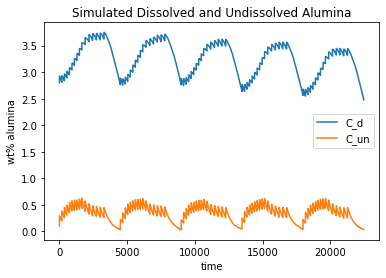

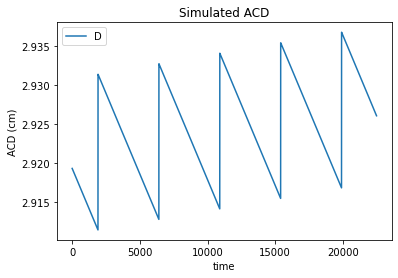

In [11]:
# simulate states with the true inputs, plot the results
xt = StateSim.xtrue(F, G, B, qstd, x0, ut, dt, True)

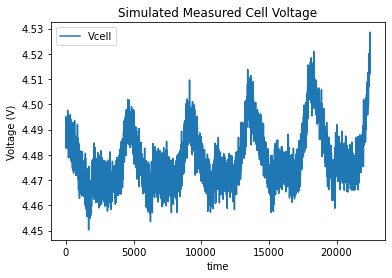

In [12]:
# Simulate the measurements and plot the results
zt = ObSim.obs(xt, ut, H, rstd, dt, True)

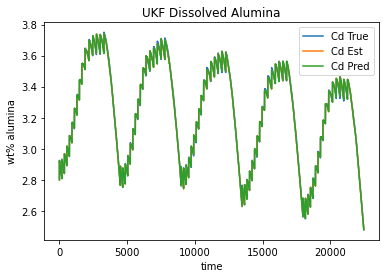

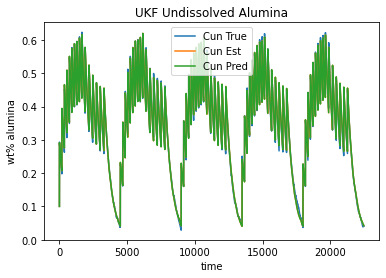

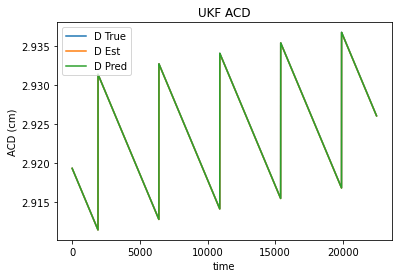

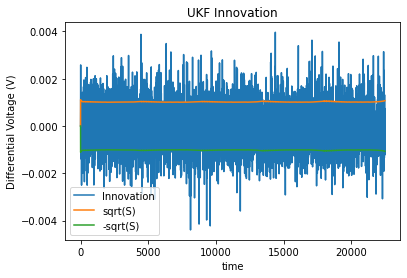

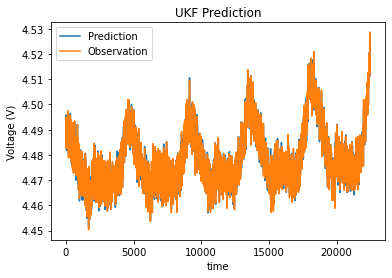

In [13]:
# Run the UKF SImulation using the nominal inputs
xest, Pest, xpred, Ppred, dz, S = UKFSim.ukf(F, G, H, B, qstd, rstd, zt, unom, x0, 0)
UKFSim.plot_ukf(xt, zt, dz, xest, xpred, dt, S)